In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io as sio
import glob


In [3]:
def load_and_process_data(directory_path, part_of_file_name):
    # get latest file from data folder that includes part_of_file_name in its name
    fileIs = sorted((f for f in glob.glob(f"{directory_path}/*") if part_of_file_name in f), key=os.path.getctime)[-1]

    # load the .mat file
    mat_contents = sio.loadmat(fileIs)
    # extract the necessary data
    sigma, eyeResp, target = mat_contents['sigma'], mat_contents['eyeX'], mat_contents['blob_x']
    mouseResp = mat_contents['mouse_x'] if fileIs.split('_')[2] == "both" else None
    if mouseResp is not None:
        mouseResp = mouseResp - np.mean(mouseResp, axis=1, keepdims=True)
    eyeResp = eyeResp - np.mean(eyeResp, axis=1, keepdims=True)
    target = target - np.mean(target, axis=1, keepdims=True)
   
    # calculate the number of trials
    nTrial = len(sigma.flatten())
    nSigma = (nTrial - 1) // 5 + 1
    nTrialPerSigma = nTrial // nSigma
    blob_widths = np.unique(sigma.flatten())

    return sigma, eyeResp, target, mouseResp, nTrial, nSigma, nTrialPerSigma, blob_widths


sigma, eyeResp, target, mouseResp = load_and_process_data("data_both", "p8")[:4]
blob_widths = np.unique(sigma.flatten())
# calculate the number of trials
nTrial = len(sigma.flatten())
nSigma = (nTrial - 1) // 5 + 1
nTrialPerSigma = nTrial // nSigma

In [4]:
# load mat file
directory_path = "data_both"  # replace with your directory path
part_of_file_name = 'p7'

# get latest file from data folder that includes 'p8' in its name
fileIs = sorted((f for f in glob.glob(f"{directory_path}/*") if part_of_file_name in f), key=os.path.getctime)[-1]
print(fileIs)
# load the .mat file
mat_contents = sio.loadmat(fileIs)

# extract the necessary data
sigma, eyeResp, target = mat_contents['sigma'], mat_contents['eyeX'], mat_contents['blob_x']
mouseResp = mat_contents['mouse_x'] if fileIs.split('_')[1] == "both" else None

# calculate the number of trials
nTrial = len(sigma.flatten())
nSigma = (nTrial - 1) // 5 + 1
nTrialPerSigma = nTrial // nSigma
blob_widths = np.unique(sigma.flatten())


data_both\p7_both_continous_psych_2024-03-20_15h09.33.361.mat


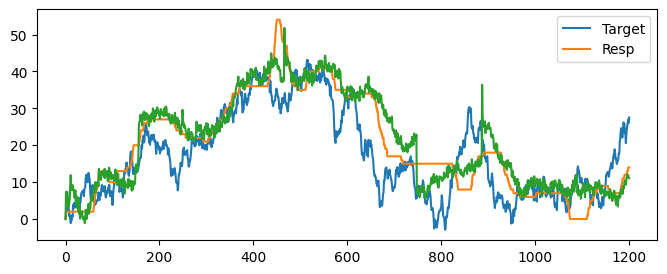

In [5]:
# plot the data
sigma, eyeResp, target, mouseResp = load_and_process_data("data_both", "p8")[:4]

trialNum=2
plt.figure(figsize=(8,3))
plt.plot(target[trialNum,:])
plt.plot(mouseResp[trialNum,:])
plt.plot(eyeResp[trialNum,:])
plt.legend(['Target','Resp'])
plt.show()



In [6]:
from scipy.ndimage import gaussian_filter1d

def smooth_data(data_to_smooth, window_size=10):
    # Create a moving average filter
    filter = np.ones(window_size) / window_size
    # Apply the filter to the response data using list comprehension
    smoothed_response = [np.convolve(trial, filter, mode='same') for trial in data_to_smooth]
    return np.squeeze(smoothed_response)
eyeResp = smooth_data(eyeResp)
#target = smooth_data(target)

In [7]:
response=eyeResp
# create key-value pairs for the dictionary of 30 trials
trial_dict = {}
for i in range(nTrial):
    trial_dict[i]={'target': target[i,60:], 'eyeResp': eyeResp[i,60:], 'sigma': sigma[0][i]} #my data
    if fileIs.split('_')[1]=="both":
        trial_dict[i]['mouseResp']=mouseResp[i,60:]

# sort the dictionary by sigma
trialDictSorted = sorted(((k, v) for k, v in trial_dict.items()), key=lambda x: x[1]['sigma']) # x[1]['sigma'] gives the value of sigma for each trial and la
tmp_trial=trialDictSorted[0][1]

## Negative Log Likelihood Uncertainty Estimates

In [8]:
from scipy.sparse import diags
import scipy.optimize as opt
def negLogLikelihood(rr, Q, X, Xhat):
    numTrials = X.shape[1]  # number of trials
    N = X.shape[0]          # number of samples

    rr = np.exp(rr)  # exponentiate observation noise variance
    pp = Q / 2 * (np.sqrt(1 + 4 * rr / Q) - 1)  # posterior variance - Eq B8
    k = (pp + Q) / (pp + Q + rr)  # Kalman Gain - eq B10
    
    # Create a sparse matrix for D
    d = diags([np.ones(N), (k - 1) * np.ones(N)], [0, -1], shape=(N, N)).toarray()  # Eq B12

    # Compute nLL using list comprehension
    nLL = -sum(-1 / (2 * k**2 * rr) * np.dot((np.dot(d, Xhat[:, i]) - k * X[:, i]).T, np.dot(d, Xhat[:, i]) - k * X[:, i]) - N / 2 * np.log(rr) - N * np.log(k) for i in range(numTrials))

    return nLL
from scipy.optimize import minimize



In [9]:
import matplotlib.cm as cm
import numpy as np

# Get the 'viridis' colormap
cmap = cm.get_cmap('rainbow')

# Generate 10 evenly spaced values between 0 and 1
values = np.linspace(0, 1, 10)

# Get 10 colors from the colormap
colors = [cmap(value) for value in values]
colors = ['#000000', '#800000', '#008000', '#000080', '#808000', '#800080', '#008080', '#606060', '#804000', '#408080']

C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\2667010660.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')


3
Optimal value for observation noise variance is 3.7222467928116467
Optimal value for observation noise variance is 3.517036409125756
Optimal value for observation noise variance is 3.298015583188759
3
Optimal value for observation noise variance is 2.717464381152288


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.429434634625851
Optimal value for observation noise variance is 2.4120641456712413
4


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.9488094664966535
Optimal value for observation noise variance is 2.743678858687384
Optimal value for observation noise variance is 2.569804735389951


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


4
Optimal value for observation noise variance is 2.7623646848456844
Optimal value for observation noise variance is 2.5743923282156316
Optimal value for observation noise variance is 2.352472687244987
5


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 3.2139770058976667
Optimal value for observation noise variance is 2.730512670804873
Optimal value for observation noise variance is 3.0010517713024205
5


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.7401062128391636
Optimal value for observation noise variance is 2.93880970559776
Optimal value for observation noise variance is 2.3559474866360572
6


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.8035367060513265
Optimal value for observation noise variance is 2.585349900937002
Optimal value for observation noise variance is 2.595437722660108
6


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.611572839237364
Optimal value for observation noise variance is 2.367482196528515
Optimal value for observation noise variance is 2.3794888875387814
7


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.871996269201076
Optimal value for observation noise variance is 2.6609873354995437
Optimal value for observation noise variance is 2.7120194624318223
7


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.8237067893909185
Optimal value for observation noise variance is 3.0554569124561173


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.3031143664490923
8
Optimal value for observation noise variance is 2.868269324255844
Optimal value for observation noise variance is 2.8419668374024507
Optimal value for observation noise variance is 2.5721708037067468
8


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.682398774314937
Optimal value for observation noise variance is 2.4869601465232445
Optimal value for observation noise variance is 2.3739960293653843
9


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.7545220228024174
Optimal value for observation noise variance is 3.3359131657297123
Optimal value for observation noise variance is 3.0222706986164853
9


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Optimal value for observation noise variance is 2.6990447453904167
Optimal value for observation noise variance is 2.560077711400145
Optimal value for observation noise variance is 2.464070626675497


C:\Users\omeru\AppData\Local\Temp\ipykernel_16364\1400087034.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(sigmas, r_values, 'k-',color=colors[numP])


Text(0, 0.5, 'Positional Uncertainty (sqrt(R))')

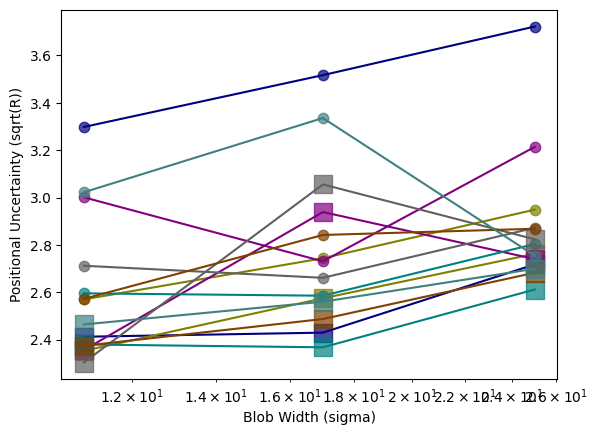

In [74]:
rValBoth_all = []
rValEye_all = []
for numP in range(3, 10):
    randomColorCode = np.random.rand(3,)
    for dataType in ["data_eye", "data_both"]:
        r_values_eye = []
        r_values_both = []
        sigma, eyeResp, target, mouseResp = load_and_process_data(dataType, 'p'+str(numP))[:4]
        print(numP)
        X = target
        if dataType == "data_both":
            Y = mouseResp
        else:
            Y = eyeResp
            #Y = smooth_data(Y)
        nLLs = []
        i=0
        # Initialize arrays to store results
        r_values = np.zeros(len(blob_widths))
        fval_values = np.zeros(len(blob_widths))
        # Plot setup
        lag=12
        clip=60

        Xc = X[:, clip:X.shape[1] -lag] - np.mean(X[:, clip:X.shape[1]-lag], axis=1)[:, np.newaxis]
        Yc = Y[:, lag+clip:] - np.mean(Y[:, lag+clip:], axis=1)[:, np.newaxis]
        results=[]
        Q=1
        # calculate intirial Guess for Q 
        rr_initial_guess = np.log(100)  # Initial guess for log observation noise variance
        # sigmas is reversed unique values of sigma
        sigmas = np.unique(sigma)[::-1]
        for i in range(len(sigmas)):
            index = [s == sigmas[i] for s in sigma]
            index=np.array(index).flatten()
            #calculate Q for each sigma as a variance of displacement
            result = minimize(negLogLikelihood, rr_initial_guess, args=(Q, Xc[index,:].T, Yc[index,:].T), method='BFGS', options={'maxiter': 1000})
            results.append(result)
            # # Store optimization results
            r_values[i] = np.sqrt(result.x[0])
            fval_values[i] = result.fun
            print('Optimal value for observation noise variance is ' + str(r_values[i]))
            # # Plot the result
            if dataType=="data_both":    
                plt.semilogx(sigmas[i], r_values[i], 's', linewidth=3, markersize=13, label=f'sigma={sigmas}',color=colors[numP], alpha=0.7)
                #r_values_both.append(r_values)

            else:
                plt.semilogx(sigmas[i], r_values[i], '.', linewidth=3, markersize=15, label=f'sigma={sigmas}',color=colors[numP], alpha=0.7)
                #r_values_eye.append(r_values)
        plt.plot(sigmas, r_values, 'k-',color=colors[numP])
        if dataType=="data_both":
            rValBoth_all.append(r_values)
        else:
            rValEye_all.append(r_values)

plt.xlabel('Blob Width (sigma)')
plt.ylabel('Positional Uncertainty (sqrt(R))')

In [59]:
flattned_rValBoth_all = [item for sublist in rValBoth_all for item in sublist]
flattned_rValEye_all = [item for sublist in rValEye_all for item in sublist]

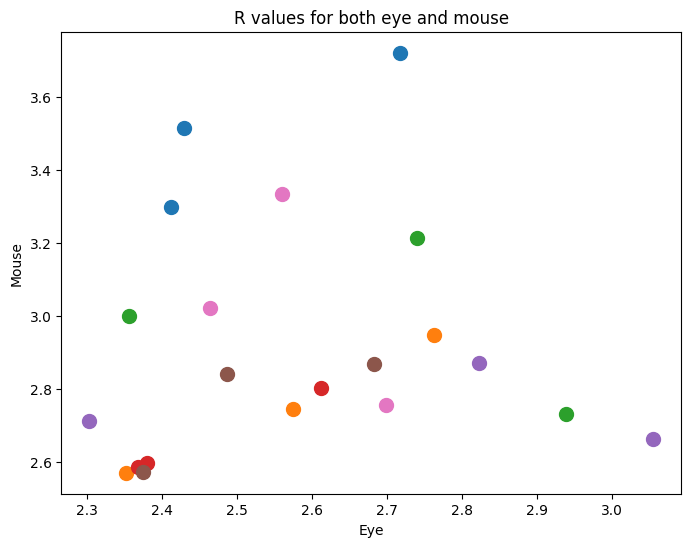

In [67]:
rValBoth_all = np.array(rValBoth_all)
rValEye_all = np.array(rValEye_all)
# Plot R values for both eye and mouse
plt.figure(figsize=(8, 6))
plt.plot(rValBoth_all.T,rValEye_all.T, 'o', markersize=10)
plt.xlabel('Eye')
plt.ylabel('Mouse')
plt.title('R values for both eye and mouse')
plt.show()
